16:58:33 1019622295.py INFO: Reading preprocess config from: ./config/lpe_config.json
16:58:33 1019622295.py INFO: Preprocess config: {'bilateral_filter': {'d': 9, 'sigmaColor': 80, 'sigmaSpace': 80}, 'histogram_equalization': {'clipLimit': 2.0, 'tileGridSize': [8, 8]}, 'disk_kernel_radius': 16, 'rect1_kernel_size': [12, 6], 'rect2_kernel_size': [23, 6], 'rect3_kernel_size': [15, 5], 'rect4_kernel_size': [18, 5], 'square_kernel_size': 3, 'sobel_kernel_size': 31}


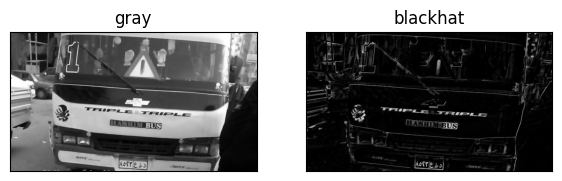

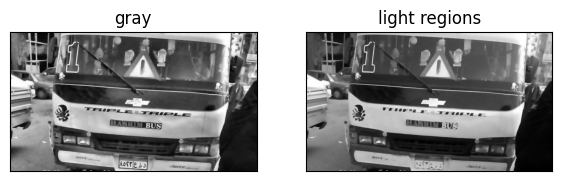

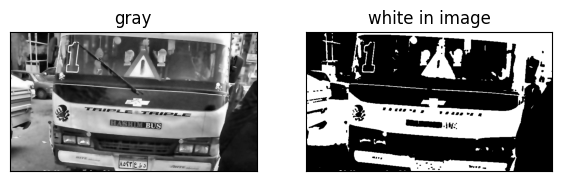

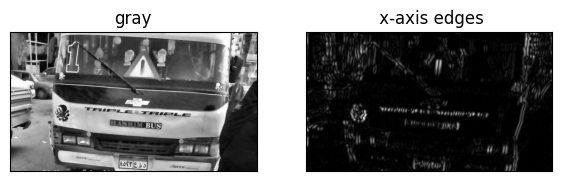

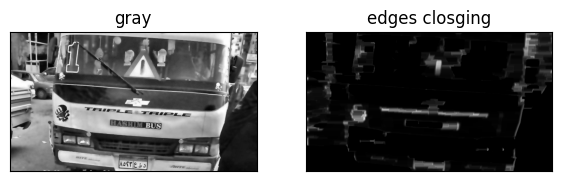

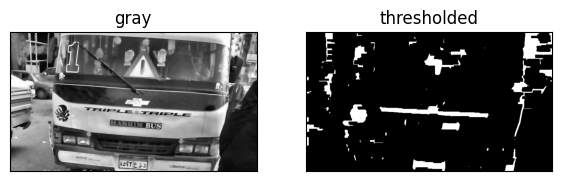

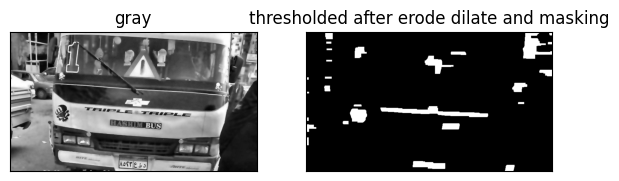

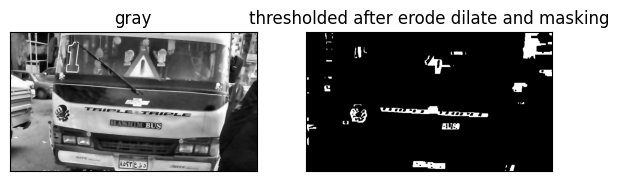

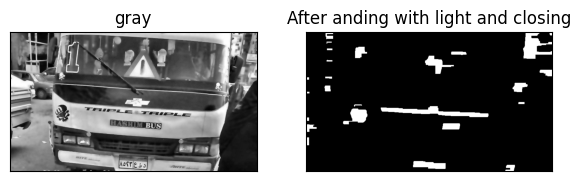

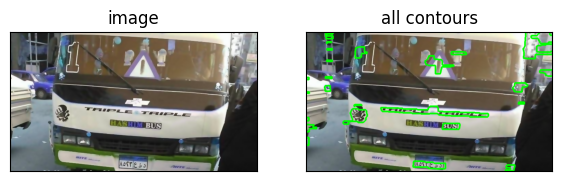

16:58:35 plate_extraction.py DEBUG: Found 20 contours
16:58:35 plate_extraction.py INFO: Distance: 22.714962005615234
16:58:35 plate_extraction.py INFO: Distance: 24.553430557250977
16:58:35 plate_extraction.py INFO: Distance: 26.281862258911133
16:58:35 plate_extraction.py INFO: Found nearest images: 2


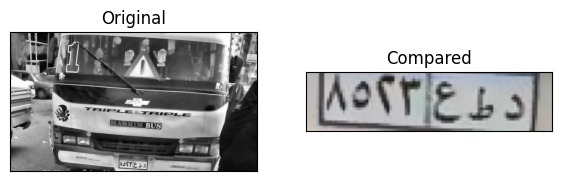

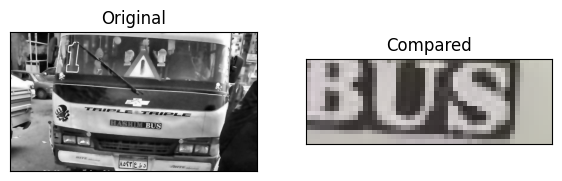

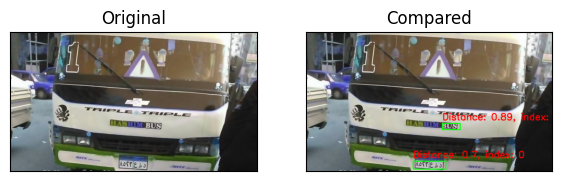

16:58:36 plate_extraction.py DEBUG: Max indices: (84, 57, 40)


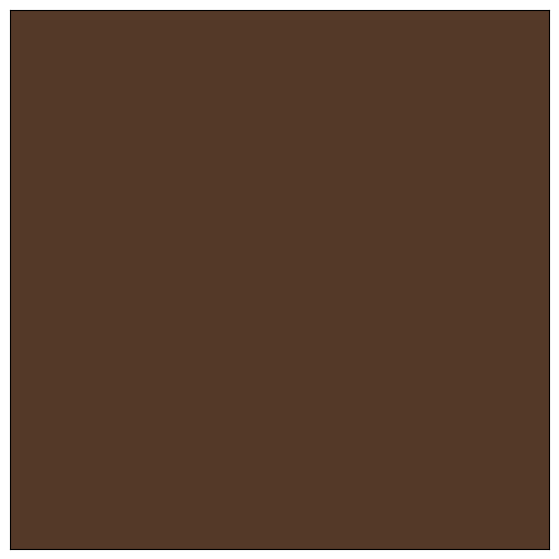

16:58:36 1019622295.py INFO: {'Private|ملاكي': 146.7140075112121, 'Diplomatic|دبلوماسي': 110.48076755707302, 'Taxi|تاكسي': 152.55163060419906, 'Customs|جمركي': 214.5203953007732, 'Bus|باص': 223.34054714717612, 'Transport|نقل': 109.1833320612629, 'Commercial|تجاري': 179.75817088522012}
16:58:36 1019622295.py INFO: Classified plate as: Transport|نقل


'Transport|نقل'

In [32]:
import json
from dataclasses import dataclass
from typing import Literal

import cv2
import numpy as np

from debug_logger.debug_logger import DebugLogger
from plate_extraction.plate_extraction import (
    area_AR_get_candidate_contours,
    area_binary_thresh_get_candidate_contours,
    extract_color_region,
    get_contours,
    hog_method_plate_detection,
)
from preprocessing.preprocessing import normalize_edges
from utils.utils import draw_contours
from utils.utils import plot_side_by_side_images as plot_images

logger = DebugLogger(name="logger")


@dataclass
class LPE_Config(object):
    bilateral_filter: dict
    histogram_equalization: dict
    disk_kernel_radius: int
    rect1_kernel_size: list
    rect2_kernel_size: list
    rect3_kernel_size: list
    rect4_kernel_size: list
    square_kernel_size: int
    sobel_kernel_size: int

    @staticmethod
    def load_from_json(filename):
        with open(filename) as config_file:
            config_data = json.load(config_file)
            return LPE_Config(**config_data)

    def __str__(self) -> str:
        return str(self.__dict__)


class LicensePlateExtractor:
    reference_features = None
    rectKern, rectKern2, rectKern3, rectKern4, squareKern = None, None, None, None, None
    config: LPE_Config = None
    colors = {
        "Private|ملاكي": (44, 112, 170),
        "Diplomatic|دبلوماسي": (81, 163, 71),
        "Taxi|تاكسي": (228, 107, 46),
        "Customs|جمركي": (247, 192, 75),
        "Bus|باص": (188, 188, 188),
        "Transport|نقل": (190, 31, 43),
        "Commercial|تجاري": (196, 169, 125),
    }

    @staticmethod
    def load_config(config_path="./config/lpe_config.json"):
        """
        Load the configuration file and initialize the LicensePlateExtractor class.

        :param config_path: (str) Path to the configuration file. Default is "./config/lpe_config.json".
        """
        LicensePlateExtractor.__read_config(config_path)
        reference_object = cv2.imread("./image_1.png")
        reference_gray = cv2.cvtColor(reference_object, cv2.COLOR_BGR2GRAY)
        reference_gray = cv2.resize(reference_gray, (128, 128))
        hog = cv2.HOGDescriptor()
        LicensePlateExtractor.reference_features = hog.compute(reference_gray)

    @staticmethod
    def __read_config(path):
        """
        Reads the preprocess configuration from the specified path.

        Parameters:
            path (str): The path to the preprocess configuration file.

        Returns:
            None
        """
        logger.info(f"Reading preprocess config from: {path}")
        LicensePlateExtractor.config = LPE_Config.load_from_json(path)
        config = LicensePlateExtractor.config
        logger.info(f"Preprocess config: {config}")
        LicensePlateExtractor.rectKern = cv2.getStructuringElement(
            cv2.MORPH_RECT,
            (
                config.rect1_kernel_size[0],
                config.rect1_kernel_size[1],
            ),
        )
        LicensePlateExtractor.rectKern2 = cv2.getStructuringElement(
            cv2.MORPH_RECT,
            (
                config.rect2_kernel_size[0],
                config.rect2_kernel_size[1],
            ),
        )
        LicensePlateExtractor.rectKern3 = cv2.getStructuringElement(
            cv2.MORPH_RECT,
            (config.rect3_kernel_size[0], config.rect3_kernel_size[1]),
        )
        LicensePlateExtractor.rectKern4 = cv2.getStructuringElement(
            cv2.MORPH_RECT,
            (config.rect4_kernel_size[0], config.rect4_kernel_size[1]),
        )
        LicensePlateExtractor.squareKern = cv2.getStructuringElement(
            cv2.MORPH_RECT,
            (config.square_kernel_size, config.square_kernel_size),
        )

    @staticmethod
    def preprocess_image(image_path):
        """
        Preprocesses an image by applying various image processing techniques.

        Args:
            image_path (str): The path to the image file.

        Returns:
            tuple: A tuple containing the preprocessed image, grayscale image before histogram equalization,
            grayscale image after histogram equalization, and the opened image.
        """
        image_path = image_path
        image = cv2.imread(image_path)
        if image is None:
            logger.error(f"Could not load image: {image_path}")
        config = LicensePlateExtractor.config
        d = config.bilateral_filter["d"]
        sigmaColor = config.bilateral_filter["sigmaColor"]
        sigmaSpace = config.bilateral_filter["sigmaSpace"]
        clipLimit = config.histogram_equalization["clipLimit"]
        tileGridSize = config.histogram_equalization["tileGridSize"]
        radius = config.disk_kernel_radius

        image = cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)
        gray_1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
        gray = clahe.apply(gray_1)
        disk_kernel = cv2.getStructuringElement(
            cv2.MORPH_ELLIPSE, (2 * radius + 1, 2 * radius + 1), (radius, radius)
        )
        opened_image = cv2.morphologyEx(gray, cv2.MORPH_OPEN, disk_kernel)
        return image, gray_1, gray, opened_image

    @staticmethod
    def extract_plate(
        image_path, detection_method: Literal["perfectAR", "hog"] = "hog"
    ):
        """
        Extracts the license plate from an image.

        Parameters:
            image_path (str): The path to the image file.
            detection_method (Literal["perfectAR", "hog"], optional): The detection method to use. Defaults to "hog".
        Returns:
            tuple: A tuple containing the following elements:
                - image (numpy.ndarray): The original image.
                - candidates (list): A list of candidate license plates.
                    Each candidate is represented as a tuple containing the following elements:
                    - candidate (numpy.ndarray): The candidate license plate image.
                    - dist (float): The distance of the candidate from the reference features.
                    - index (int): The index of the candidate.
                    - box (int,int,int,int): The bounding box of the candidate.
                - annotated_image (numpy.ndarray): The original image with annotated license plate candidates.
        """
        image, gray_1, gray, opened_image = LicensePlateExtractor.preprocess_image(
            image_path
        )

        rectKern = LicensePlateExtractor.rectKern
        rectKern2 = LicensePlateExtractor.rectKern2
        rectKern3 = LicensePlateExtractor.rectKern3
        rectKern4 = LicensePlateExtractor.rectKern4
        squareKern = LicensePlateExtractor.squareKern

        """perform a blackhat morphological operation to reveal dark characters (letters, digits, and symbols)
        against light backgrounds (the license plate itself)"""
        blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)
        plot_images(gray_1, blackhat, "gray", "blackhat")

        """ find regions in the image that are light and may contain license plate characters
        find regions in the image that are light and may contain license plate characters """
        light = cv2.morphologyEx(gray_1, cv2.MORPH_CLOSE, squareKern)

        plot_images(gray, light, "gray", "light regions")
        light = cv2.threshold(light, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]

        plot_images(gray, light, "gray", "white in image")

        """ detect edges in the image and emphasize the boundaries of
        the characters in the license plate"""
        gradX = cv2.Sobel(
            blackhat,
            cv2.CV_32F,
            1,
            0,
            ksize=LicensePlateExtractor.config.sobel_kernel_size,
        )
        gradX = normalize_edges(gradX)
        plot_images(gray, gradX, "gray", " x-axis edges")

        """smooth to group the regions that may contain boundaries to license plate characters"""
        gradXX = cv2.bitwise_and(gradX, light, mask=light)

        gradX = cv2.GaussianBlur(gradX, (9, 9), 2)

        gradX = cv2.morphologyEx(gradXX, cv2.MORPH_CLOSE, rectKern2)
        plot_images(gray, gradX, "gray", "edges closging")

        thresh = cv2.threshold(gradX, 40, 255, cv2.THRESH_BINARY)[1]

        plot_images(gray, thresh, "gray", "thresholded")

        """ there are many other large white regions as well
            perform a series of erosions and dilations in an attempt to denoise
        """

        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, rectKern3)
        plot_images(gray, thresh, "gray", "thresholded after erode dilate and masking")

        """
        light image serves as our mask for a bitwise-AND between the thresholded result and
        the light regions of the image to reveal the license plate candidates.
        follow with a couple of dilations and an erosion
        to fill holes and clean up the image
        """
        thresh = cv2.bitwise_and(thresh, thresh, mask=light)
        plot_images(gray, thresh, "gray", "thresholded after erode dilate and masking")

        # thresh = cv2.dilate(thresh,cv2.getStructuringElement(cv2.MORPH_DILATE, (7, 6)), iterations=1)
        # thresh = cv2.erode(thresh,cv2.getStructuringElement(cv2.MORPH_RECT, (8, 5)), iterations=1)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, rectKern4)

        plot_images(gray, thresh, "gray", "After anding with light and closing")

        """
        show me all contours
        """
        all_Contours = draw_contours(thresh.copy(), image.copy())

        plot_images(image, all_Contours, "image", "all contours")

        # TODO top K contours as option/config
        contours = get_contours(thresh.copy(), sort_fn=cv2.contourArea, top=20)

        # TODO contour and plate detection method
        # if detection_method == "perfectAR"
        # elif detection_method == "hog"
        images_set = area_binary_thresh_get_candidate_contours(contours, image, gray)
        candidates = hog_method_plate_detection(
            images_set, LicensePlateExtractor.reference_features
        )

        for candidate, _, _, _ in candidates:
            plot_images(gray, candidate)
        # Annotate
        annotated_image = image.copy()
        i = 0
        for _, dist, _, (box) in candidates:
            (x, y, w, h) = box
            annotated_image = cv2.rectangle(
                annotated_image, (x, y), (x + w, y + h), (0, 255, 0), 2
            )
            # Annotate text above rectangle
            annotated_image = cv2.putText(
                annotated_image,
                "Distance: {}, index: {}".format(round(dist, 2), i),
                (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.9,
                (255, 1, 0),
                2,
            )
            i += 1
        # plot_images(image, annotated_image)
        return image, candidates, annotated_image

    @staticmethod
    def extract_type(original_image, x, y, w, h):
        """
        Extracts the type of a license plate from an image.

        Args:
            original_image (numpy.ndarray): The original image containing the license plate.
            x (int): The x-coordinate of the top-left corner of the license plate region.
            y (int): The y-coordinate of the top-left corner of the license plate region.
            w (int): The width of the license plate region.
            h (int): The height of the license plate region.

        Returns:
            str: The extracted type of the license plate.

        """
        plate_color = extract_color_region(original_image, x, y, w, h)
        # Measure distance to colors
        distances = {}
        for color_name, color_values in LicensePlateExtractor.colors.items():
            distances[color_name] = np.linalg.norm(
                np.array(color_values) - np.array(plate_color)
            )
        logger.info(distances)
        # Find closest color
        closest_name = min(distances, key=distances.get)
        logger.info(f"Classified plate as: {closest_name}")
        return closest_name

    @staticmethod
    def get_plate_number(image):
        # TODO get plate number
        pass

    @staticmethod
    def get_plate_region(image):
        # TODO get plate region
        pass


LicensePlateExtractor.load_config()

image, candidates, annotated_image = LicensePlateExtractor.extract_plate(
    "../data/Vehicles/0643.jpg"
)
original_image = cv2.imread("../data/Vehicles/0643.jpg")
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plot_images(image, annotated_image)
LicensePlateExtractor.extract_type(original_image, *candidates[0][3])
